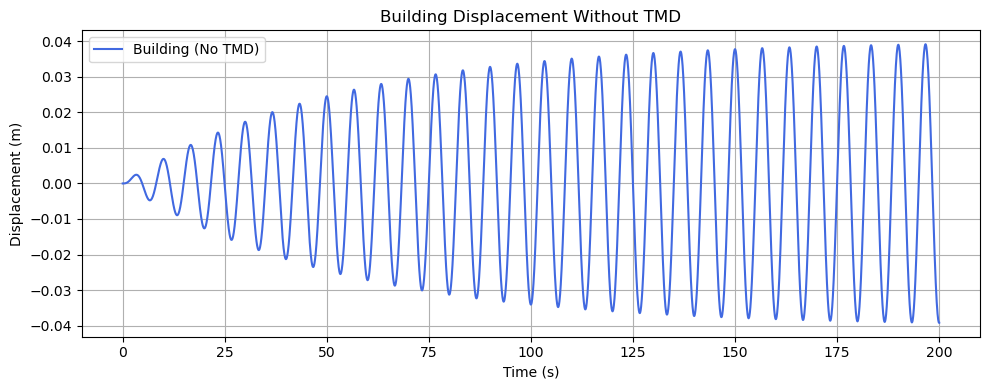

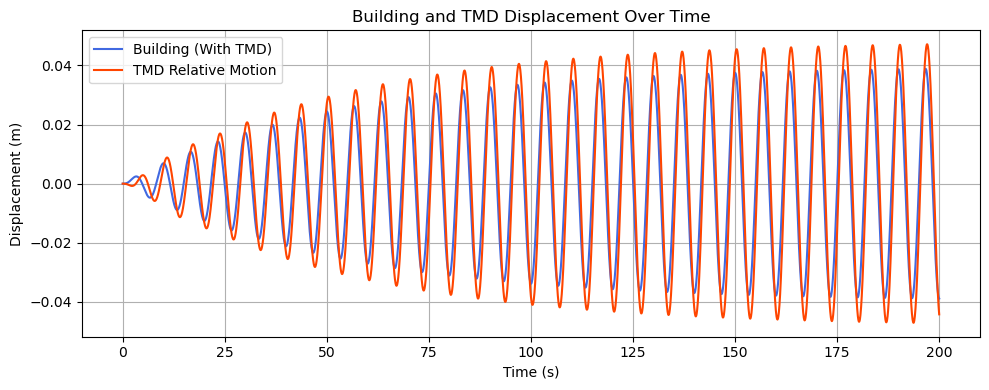

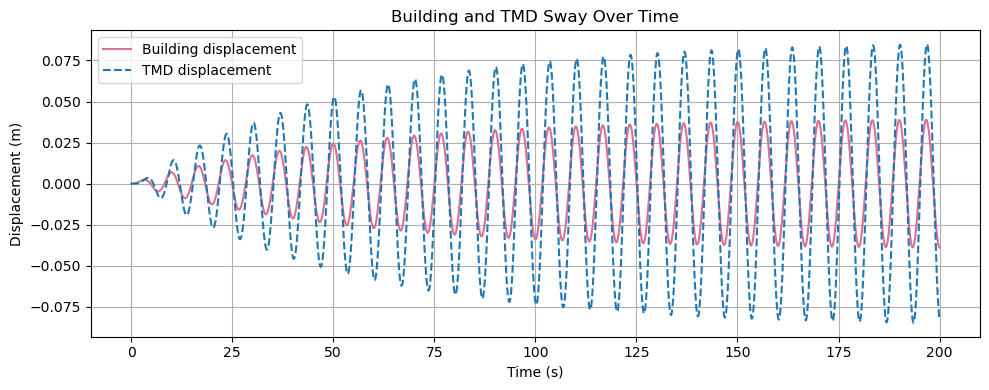

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import solve_ivp


# Building Parameters
m1 = 7e8  # kg: 700,000 tons
f1 = 0.15  # Hz
omega1 = 2 * np.pi * f1  # rad/s
zeta1 = 0.02  # damping ratio

k1 = m1 * omega1**2
c1 = 2 * zeta1 * m1 * omega1

# TMD Parameters
m2 = 6e5  # kg: 600 tons
f2 = 0.2  # Hz
omega2 = 2 * np.pi * f2  # rad/s
zeta2 = 0.1  # damping ratio

k2 = m2 * omega2**2
c2 = 2 * zeta2 * m2 * omega2

# Wind force (sinusoidal at resonance frequency)
def wind_force(t):
    return 1e6 * np.sin(2 * np.pi * f1 * t)

# Time settings
t_span = (0, 200)  # simulate for [0, 200] seconds
t_eval = np.linspace(*t_span, 5000)

# ODEs
# Building without TMD (1 DOF)
def building_only_ode(t, y):
    x1, x1_dot = y
    x1_ddot = (wind_force(t) - c1 * x1_dot - k1 * x1) / m1
    return [x1_dot, x1_ddot]

y0_building = [0, 0]  # initial displacement and velocity
sol_building = solve_ivp(building_only_ode, t_span, y0_building, t_eval=t_eval)

# Building with TMD (2 DOF)
def building_with_tmd_ode(t, y):
    x1, x1_dot, x2, x2_dot = y
    F_ext = wind_force(t)

    x1_ddot = (F_ext - c1 * x1_dot - k1 * x1 - c2 * (x1_dot - x2_dot) - k2 * (x1 - x2)) / m1
    x2_ddot = (c2 * (x1_dot - x2_dot) + k2 * (x1 - x2)) / m2

    return [x1_dot, x1_ddot, x2_dot, x2_ddot]

y0_tmd = [0, 0, 0, 0]
sol_tmd = solve_ivp(building_with_tmd_ode, t_span, y0_tmd, t_eval=t_eval)

# Extract solutions
t = sol_tmd.t
x1_no_tmd = sol_building.y[0]
x1_with_tmd = sol_tmd.y[0]
x2_with_tmd = sol_tmd.y[2]
tmd_relative_disp = x2_with_tmd - x1_with_tmd

# Plot 1: Building displacement without TMD
plt.figure(figsize=(10, 4))
plt.plot(t, x1_no_tmd, label="Building (No TMD)", color='royalblue')
plt.title("Building Displacement Without TMD")
plt.xlabel("Time (s)")
plt.ylabel("Displacement (m)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot 2: Building sway with TMD vs. TMD displacement
plt.figure(figsize=(10, 4))
plt.plot(t, x1_with_tmd, label="Building (With TMD)", color='royalblue')
plt.plot(t, tmd_relative_disp, label="TMD Relative Motion", color='orangered')
plt.title("Building and TMD Displacement Over Time")
plt.xlabel("Time (s)")
plt.ylabel("Displacement (m)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot 3: TMD reduces sway of Building
plt.figure(figsize=(10, 4))
plt.plot(t, x1_with_tmd, label='Building displacement', color='palevioletred')
plt.plot(t, x2_with_tmd, label='TMD displacement', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Displacement (m)')
plt.title('Building and TMD Sway Over Time')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Excel tables

# Sample indices for 10 points evenly spaced
indices = np.linspace(0, len(t) - 1, 10, dtype=int)

# Table 1: No TMD
df1_summary = pd.DataFrame({
    "Metric": ["Max Displacement", "Min Displacement", "Peak-to-Peak"],
    "Value (m)": [np.max(x1_no_tmd), np.min(x1_no_tmd), np.max(x1_no_tmd) - np.min(x1_no_tmd)]
})
df1_samples = pd.DataFrame({
    "Time (s)": t[indices],
    "Building No TMD (m)": x1_no_tmd[indices],
})

# Table 2: With TMD + Relative Motion
df2_summary = pd.DataFrame({
    "Metric": ["Building Max", "Building Min", "Building Peak-to-Peak",
               "TMD Max (Rel)", "TMD Min (Rel)", "TMD Peak-to-Peak"],
    "Value (m)": [np.max(x1_with_tmd), np.min(x1_with_tmd), np.max(x1_with_tmd) - np.min(x1_with_tmd),
                  np.max(tmd_relative_disp), np.min(tmd_relative_disp), np.max(tmd_relative_disp) - np.min(tmd_relative_disp)]
})
df2_samples = pd.DataFrame({
    "Time (s)": t[indices],
    "Building With TMD (m)": x1_with_tmd[indices],
    "TMD Relative Disp. (m)": tmd_relative_disp[indices],
})

# Table 3: TMD Absolute Motion
df3_summary = pd.DataFrame({
    "Metric": ["TMD Abs Max", "TMD Abs Min", "TMD Abs Peak-to-Peak"],
    "Value (m)": [np.max(x2_with_tmd), np.min(x2_with_tmd), np.max(x2_with_tmd) - np.min(x2_with_tmd)]
})
df3_samples = pd.DataFrame({
    "Time (s)": t[indices],
    "TMD Absolute Disp. (m)": x2_with_tmd[indices],
})

# --- Export to Excel ---
with pd.ExcelWriter("building_tmd_results.xlsx") as writer:
    # Sheet 1
    df1_summary.to_excel(writer, sheet_name="No_TMD_Summary", index=False)
    df1_samples.to_excel(writer, sheet_name="No_TMD_Summary", index=False, startrow=len(df1_summary) + 2)

    # Sheet 2
    df2_summary.to_excel(writer, sheet_name="With_TMD_Summary", index=False)
    df2_samples.to_excel(writer, sheet_name="With_TMD_Summary", index=False, startrow=len(df2_summary) + 2)

    # Sheet 3
    df3_summary.to_excel(writer, sheet_name="TMD_Absolute_Summary", index=False)
    df3_samples.to_excel(writer, sheet_name="TMD_Absolute_Summary", index=False, startrow=len(df3_summary) + 2)



In [47]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp

# Your building and TMD parameters (unchanged)
m1 = 7e8
f1 = 0.15
omega1 = 2 * np.pi * f1
zeta1 = 0.02
k1 = m1 * omega1**2
c1 = 2 * zeta1 * m1 * omega1

m2 = 6e5

# Wind force (unchanged)
def wind_force(t):
    return 1e6 * np.sin(2 * np.pi * f1 * t)

t_span = (0, 200)
t_eval = np.linspace(*t_span, 5000)

# ODE system with variable c2 and k2
def building_with_tmd_ode(t, y, c2, k2):
    x1, x1_dot, x2, x2_dot = y
    F_ext = wind_force(t)

    x1_ddot = (F_ext - c1 * x1_dot - k1 * x1 - c2 * (x1_dot - x2_dot) - k2 * (x1 - x2)) / m1
    x2_ddot = (c2 * (x1_dot - x2_dot) + k2 * (x1 - x2)) / m2

    return [x1_dot, x1_ddot, x2_dot, x2_ddot]

# Parameter sweep ranges
freqs = np.arange(0.15, 0.26, 0.02)  # TMD frequencies from 0.15 to 0.25 Hz
zeta2s = np.arange(0.0, 0.31, 0.05)  # Damping ratios from 0 to 0.3

results = []

for f2_test in freqs:
    omega2_test = 2 * np.pi * f2_test
    for zeta2_test in zeta2s:
        k2_test = m2 * omega2_test**2
        c2_test = 2 * zeta2_test * m2 * omega2_test
        
        y0_tmd = [0, 0, 0, 0]
        sol = solve_ivp(building_with_tmd_ode, t_span, y0_tmd, args=(c2_test, k2_test), t_eval=t_eval)
        
        x1 = sol.y[0]
        max_disp = np.max(np.abs(x1))
        
        results.append({
            "f2 (Hz)": f2_test,
            "zeta2": zeta2_test,
            "k2 (N/m)": k2_test,
            "c2 (Ns/m)": c2_test,
            "Max Building Displacement (m)": max_disp
        })

df_results = pd.DataFrame(results)
df_results.to_excel("parameter_sweep_results.xlsx", index=False)

print("✅ Parameter sweep complete and results saved to 'parameter_sweep_results.xlsx'")


✅ Parameter sweep complete and results saved to 'parameter_sweep_results.xlsx'


In [49]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import solve_ivp

# --- Fixed Parameters ---

# Building Parameters (fixed)
m1 = 7e8  # kg: 700,000 tons
f1 = 0.15  # Hz (building frequency)
omega1 = 2 * np.pi * f1  # rad/s
zeta1 = 0.02  # damping ratio

k1 = m1 * omega1**2
c1 = 2 * zeta1 * m1 * omega1

# TMD Parameters (mass fixed, frequency and damping will sweep)
m2 = 6e5  # kg: 600 tons

# Wind force (sinusoidal at building frequency)
def wind_force(t):
    return 1e6 * np.sin(2 * np.pi * f1 * t)

# Time settings
t_span = (0, 200)
t_eval = np.linspace(*t_span, 5000)

# Initial conditions for ODE
y0_tmd = [0, 0, 0, 0]

# --- Parameter Sweep ---

zeta2_values = np.linspace(0.01, 0.15, 6)  # 6 points from 0.01 to 0.15
f2_values = np.linspace(0.1, 0.3, 7)        # 7 points from 0.1 to 0.3 Hz

results = []

for z2 in zeta2_values:
    for f_2 in f2_values:
        omega2 = 2 * np.pi * f_2
        k2 = m2 * omega2**2
        c2 = 2 * z2 * m2 * omega2
        
        # Define ODE system with current params
        def building_with_tmd_ode(t, y):
            x1, x1_dot, x2, x2_dot = y
            F_ext = wind_force(t)
            x1_ddot = (F_ext - c1 * x1_dot - k1 * x1 - c2 * (x1_dot - x2_dot) - k2 * (x1 - x2)) / m1
            x2_ddot = (c2 * (x1_dot - x2_dot) + k2 * (x1 - x2)) / m2
            return [x1_dot, x1_ddot, x2_dot, x2_ddot]
        
        # Solve ODE
        sol = solve_ivp(building_with_tmd_ode, t_span, y0_tmd, t_eval=t_eval)
        x1 = sol.y[0]  # Building displacement
        x2 = sol.y[2]  # TMD displacement
        tmd_rel = x2 - x1  # Relative motion
        
        # Collect key metrics
        results.append({
            "zeta2": z2,
            "f2 (Hz)": f_2,
            "Building Max Disp (m)": np.max(x1),
            "Building Min Disp (m)": np.min(x1),
            "Building Peak-to-Peak (m)": np.max(x1) - np.min(x1),
            "TMD Max Relative Disp (m)": np.max(tmd_rel),
            "TMD Min Relative Disp (m)": np.min(tmd_rel),
            "TMD Peak-to-Peak (m)": np.max(tmd_rel) - np.min(tmd_rel),
        })

# Convert to DataFrame and save to Excel
df_sweep = pd.DataFrame(results)
df_sweep.to_excel("building_tmd_parameter_sweep.xlsx", index=False)
print("✅ Parameter sweep complete! Results saved to 'building_tmd_parameter_sweep.xlsx'")


✅ Parameter sweep complete! Results saved to 'building_tmd_parameter_sweep.xlsx'
